# Cryogenic Pump Feature Engineering
Jared Nielsen

In [45]:
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import seaborn as sns
import sys

plt.rcParams['figure.figsize'] = 15,3
blue = '#1f77b4'
pd.set_option('precision', 2)

## Load the Cleaned Data

In [29]:
cryo_csv = 'cryos_cleaned.csv'
turbo_csv = 'turbos_cleaned.csv'

start = datetime.now()
x_cryo = pd.read_csv(cryo_csv, parse_dates=['timestamp'])
elapsed = (datetime.now() - start).total_seconds()

print("Cryos Shape: {}".format(x_cryo.shape))
print("Time: {}".format(elapsed))

start = datetime.now()
x_turbo = pd.read_csv(turbo_csv, parse_dates=['timestamp'])
elapsed = (datetime.now() - start).total_seconds()

print("Turbos Shape: {}".format(x_turbo.shape))
print("Time: {}".format(elapsed))

Cryos Shape: (2005273, 8)
Time: 1.980695
Turbos Shape: (409653, 8)
Time: 0.435867


## Samples

In [3]:
x_cryo.head()

,unitsequence,timestamp,temp1,temp2,heater1,heater2,tcpressure,currentregen
0,17340010,2018-04-10 19:25:00,65.0,13.5,0.0,1.0,0.4,P
1,17340010,2018-04-10 19:26:00,64.9,13.5,0.0,1.0,0.4,P
2,17340010,2018-04-10 19:27:00,65.0,13.5,0.0,1.0,0.4,P
3,17340010,2018-04-10 19:28:00,65.0,13.5,0.0,1.0,0.4,P
4,17340010,2018-04-10 19:29:00,64.9,13.5,0.0,1.0,0.4,P


In [4]:
x_turbo.head()

,unitsequence,timestamp,uppervalue,lowervalue,rotorspeed,controllertemp,dcvoltage,motorcurrent
0,16776830,2018-04-10 19:25:00,2.0,2.0,584.0,144.0,122.0,0.8
1,16776830,2018-04-10 19:26:00,2.0,2.0,584.0,144.0,122.0,0.8
2,16776830,2018-04-10 19:27:00,2.0,2.0,584.0,144.0,122.0,0.7
3,16776830,2018-04-10 19:28:00,2.0,2.0,584.0,143.0,123.0,0.8
4,16776830,2018-04-10 19:29:00,2.0,2.0,584.0,143.0,122.0,0.8


## Initial Visualization

Experiments have shown that turbos have data with more variation than cryos, so we start our analysis by looking at turbo pumps.  

Let's pick the turbo pump that has the longest-running interval and analyze it.  
Try `unitsequence = 16775261`. This has `37,924` elements.  

So there are correlations going on, though they're extremely obvious. Motor speed corresponds with motor temperature - who knew? There's a lot of feature engineering to be done here, but the data is clean and ready.  

In [8]:
def get_unitsequences(x_subset):
    return x_subset['unitsequence'].unique()

def get_pump(x_subset, unitsequence):
    return x_subset[x_subset['unitsequence'] == unitsequence]

def get_intervals(x_pump):
    """
    Parameters:
        x_pump (DataFrame): output of get_pump().
    Returns:
        intervals (list(DataFrame)): the DataFrame intervals, ordered by time.
    """
    x_pump_sorted = x_pump.sort_values("timestamp").copy()
    interval_desc = (x_pump_sorted["timestamp"].diff() > pd.Timedelta(minutes=30)).cumsum()
    intervals = [v for k,v in x_pump_sorted.groupby(interval_desc)]
    return intervals

def plot_interval(interval, val_names, title=None):
    interval.plot(x='timestamp', y=val_names,
                subplots=True, layout=(2,2), marker='o', linestyle='None', color=blue,
                markersize=3, figsize=(20,10))
    if title:
        plt.suptitle(title)
    plt.show()

In [31]:
turbo_cols = list(x_turbo)
print(turbo_cols)
us = 16775261 # turbo unit_sequence
unique_us = get_unitsequences(x_turbo)
print(unique_us)

pump = x_turbo[x_turbo['unitsequence'] == us] # single turbo pump
pump.head()

['unitsequence', 'timestamp', 'uppervalue', 'lowervalue', 'rotorspeed', 'controllertemp', 'dcvoltage', 'motorcurrent']
[16776830 16775765 16775766 17337958 16776829 17337419 17337512 16775261
 17339051 16776263 16776262]


,unitsequence,timestamp,uppervalue,lowervalue,rotorspeed,controllertemp,dcvoltage,motorcurrent
1914,16775261,2018-04-10 19:25:00,2.0,13.0,550.0,147.0,122.0,0.5
1915,16775261,2018-04-10 19:26:00,2.0,13.0,545.0,147.0,122.0,0.5
1916,16775261,2018-04-10 19:27:00,2.0,13.0,545.0,147.0,122.0,0.5
1917,16775261,2018-04-10 19:28:00,2.0,13.0,545.0,148.0,122.0,0.5
1918,16775261,2018-04-10 19:29:00,2.0,13.0,545.0,147.0,122.0,0.5


ms: (8892, 8)


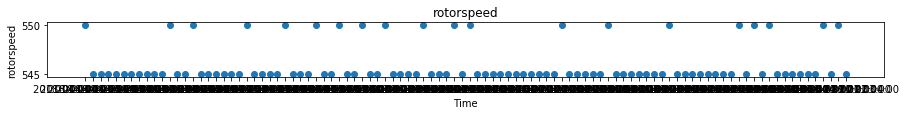

In [21]:
def plot_over_time(t, y, desc):
    fig = plt.figure(figsize=(15,1))
    ax = fig.add_subplot(111)
    ax.plot(t, y, 'o')
    ax.set_xlabel("Time")
    ax.set_ylabel(desc)
    ax.set_title(desc)
    plt.show()

def time_slice(m):
    dt1 = '2018-05-01 00:00:00'
#     dt2 = '2018-06-27 06:00:00'
    ms = m[(dt1 <= m['timestamp'])] #& (m['timestamp'] < dt2)]
    print("ms:", ms.shape)  
    return ms
    
n_timesteps, n_cols = pump.shape
pump_slice = time_slice(pump)
pump_slice = pump
t = pump_slice["timestamp"].values
cols = ["motorspeed"]

n = 100
turbo_cols = ["rotorspeed"]
for col in turbo_cols:
    plot_over_time(t[:n], pump_slice[col].values[:n], col)

## Clustering Algorithm (Feature Engineering)

We look for time discontinuities greater than 30 minutes and separate into intervals based on that.  

All the clusters for unit_sequence 16775261
No. Clusters: 2


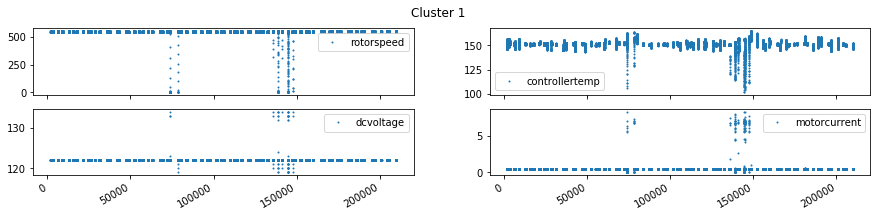

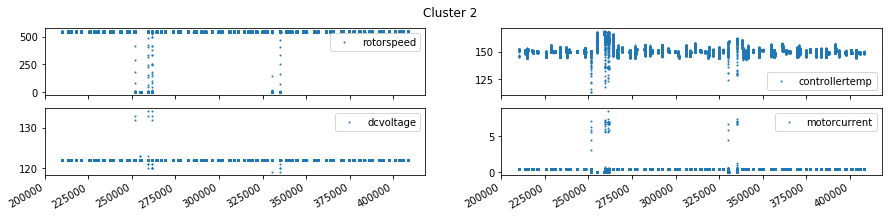

done


In [42]:
def get_clusters(df, unit_sequence_id):
    """
    Parameters:
        unit_sequence_id (int): the id of the pump (fx -18202).
        # col_name (str): the column to extract data for (fx "controllertemp")
    Returns:
        clusters (list(DataFrame)): the DataFrame clusters, ordered by time.
    """
    dfc = df[df["unitsequence"] == unit_sequence_id].sort_values("timestamp").copy()
    cluster = (dfc["timestamp"].diff() > pd.Timedelta(minutes=30)).cumsum()
    dfc = [v for k,v in dfc.groupby(cluster)]
    return dfc

def plot_cluster(cluster, col_names, title=None):
    cluster.plot(y=col_names,
                subplots=True, layout=(2,2), marker='o', linestyle='None', color=blue,
                markersize=1)
    if title:
        plt.suptitle(title)
    plt.show()
    
def plot_cluster_magnets(cluster, title=None):
    magcurrents = ["magcurrent{}".format(i) for i in range(9)]
    cluster.plot(y=magcurrents,
                subplots=True, layout=(3,3), marker='o', linestyle='None', color=blue,
                markersize=1, figsize=(10,10))
    if title:
        plt.suptitle(title)
    plt.show()

clusters = get_clusters(pump, us)
col_names = ["rotorspeed", "controllertemp", "dcvoltage", "motorcurrent"]
print("All the clusters for unit_sequence {}".format(us))
print("No. Clusters:", len(clusters))
for i, cluster in enumerate(clusters):
    plot_cluster(cluster, col_names=col_names, title="Cluster {}".format(i+1))
    if i == 1:
        break
        
print("done")

## Linear Regression

Clearly the slopes are all zero. However, the intercepts appear to vary, for example with `rotorspeed`.  
This signifies that `rotorspeed` may be an important feature in unsupervised clustering.  

In [55]:
col_names = ["rotorspeed", "controllertemp", "dcvoltage", "motorcurrent"]
for i, cluster in enumerate(clusters):
    print("Cluster {}".format(i))
    t = np.arange(len(cluster))
    for col in col_names:
        slope, intercept, _, _, _ = stats.linregress(t, cluster[col])
        print("{} - Slope: {:.3f}, Intercept: {:.3f}".format(col, slope, intercept))
    print()

Cluster 0
rotorspeed - Slope: -0.000, Intercept: 541.071
controllertemp - Slope: -0.000, Intercept: 151.051
dcvoltage - Slope: 0.000, Intercept: 122.002
motorcurrent - Slope: 0.000, Intercept: 0.495

Cluster 1
rotorspeed - Slope: 0.003, Intercept: 495.569
controllertemp - Slope: -0.000, Intercept: 151.882
dcvoltage - Slope: -0.000, Intercept: 122.009
motorcurrent - Slope: 0.000, Intercept: 0.487

